# Test transmission performance metrics for the AWGN channel

In [1]:
from commpy.modulation import QAMModem
from optic.metrics import signal_power, monteCarloGMI, monteCarloMI, fastBERcalc
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from tqdm.notebook import tqdm
from numba import njit

In [3]:
from scipy import special as sp

def Qfunc(x):
    return 0.5-0.5*sp.erf(x/np.sqrt(2))

def theoryBER(M, EbN0, constType):
    
    EbN0lin = 10**(EbN0/10)        
    k  = np.log2(M) 
    
    if constType == 'qam':
        L  = np.sqrt(M)      
        Pb = 2*(1-1/L)/np.log2(L)*Qfunc(np.sqrt(3*np.log2(L)/(L**2-1)*(2*EbN0lin)))
        
    elif constType == 'psk':
        Ps = 2*Qfunc(np.sqrt(2*k*EbN0lin)*np.sin(np.pi/M))
        Pb = Ps/k
    
    return Pb  

@njit
def awgn(tx, noiseVar):
    
    σ        = np.sqrt(noiseVar)
    noise    = np.random.normal(0,σ, tx.size) + 1j*np.random.normal(0,σ, tx.size)
    noise    = 1/np.sqrt(2)*noise
    
    rx = tx + noise
    
    return rx

## Test bit-error-rate (BER) versus signal-to-noise ratio per bit ($E_b/N_0$)

In [3]:
# Run BER vs Ebn0 Monte Carlo simulation 

qamOrder  = [4, 16, 64, 256, 1024, 4096]  # Modulation order

EbN0dB_  = np.arange(-2, 35, 1)
BER      = np.zeros((len(EbN0dB_),len(qamOrder)))
BER[:]   = np.nan

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)
    for indSNR in tqdm(range(EbN0dB_.size)):

        EbN0dB = EbN0dB_[indSNR]

        # generate random bits
        bitsTx = np.random.randint(2, size=2**19)    

        # Map bits to constellation symbols
        mod = QAMModem(m=M)
        symbTx = mod.modulate(bitsTx)

        # Normalize symbols energy to 1
        symbTx = symbTx/np.sqrt(mod.Es)

        # AWGN    
        snrdB    = EbN0dB + 10*np.log10(np.log2(M))
        noiseVar = 1/(10**(snrdB/10))

        symbRx = awgn(symbTx, noiseVar)

        # BER calculation
        BER[indSNR, ii], _, _ = fastBERcalc(symbRx, symbTx, mod)
        
        if BER[indSNR, ii] == 0:              
            break

run sim: M =  4



run sim: M =  16



run sim: M =  64



run sim: M =  256



run sim: M =  1024



run sim: M =  4096


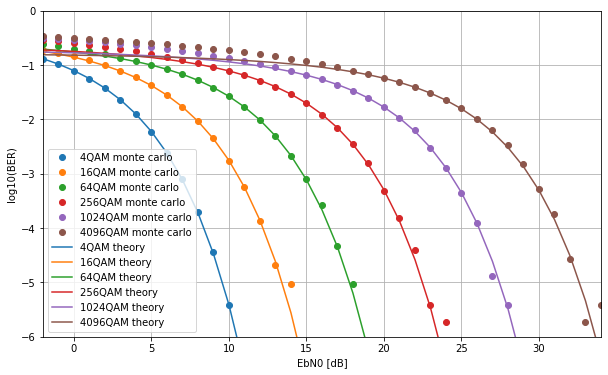

In [4]:
# Plot simulation results and theoretical curves        
BER[BER==0] = np.nan

plt.figure(figsize=(10,6))
for ii, M in enumerate(qamOrder):
    plt.plot(EbN0dB_, np.log10(BER[:,ii]),'o', label=str(M)+'QAM monte carlo')

plt.gca().set_prop_cycle(None)

for M in qamOrder:
    BERtheory = theoryBER(M, EbN0dB_,'qam')
    BERtheory[BERtheory==0] = np.nan
    plt.plot(EbN0dB_, np.log10(BERtheory),'-', label=str(M)+'QAM theory')

plt.xlim(min(EbN0dB_), max(EbN0dB_))
plt.ylim(-6, 0)
plt.legend();
plt.xlabel('EbN0 [dB]');
plt.ylabel('log10(BER)');
plt.grid()

## Test generalized mutual information (GMI) versus signal-to-noise ratio (SNR)

In [5]:
# Run GMI vs SNR Monte Carlo simulation 

qamOrder  = [4, 16, 64, 256, 1024, 4096]  # Modulation order

SNR  = np.arange(-2, 35, 1)
GMI  = np.zeros((len(SNR),len(qamOrder)))

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)
    for indSNR in tqdm(range(SNR.size)):

        snrdB = SNR[indSNR]

        # generate random bits
        bitsTx   = np.random.randint(2, size=2**18)    

        # Map bits to constellation symbols
        mod = QAMModem(m=M)
        symbTx = mod.modulate(bitsTx)

        # Normalize symbols energy to 1
        symbTx = symbTx/np.sqrt(mod.Es)

        # AWGN    
        noiseVar = 1/(10**(snrdB/10))

        symbRx = awgn(symbTx, noiseVar)

        # GMI estimation
        GMI[indSNR, ii], _  = monteCarloGMI(symbRx, symbTx, mod)

run sim: M =  4



run sim: M =  16



run sim: M =  64



run sim: M =  256



run sim: M =  1024



run sim: M =  4096


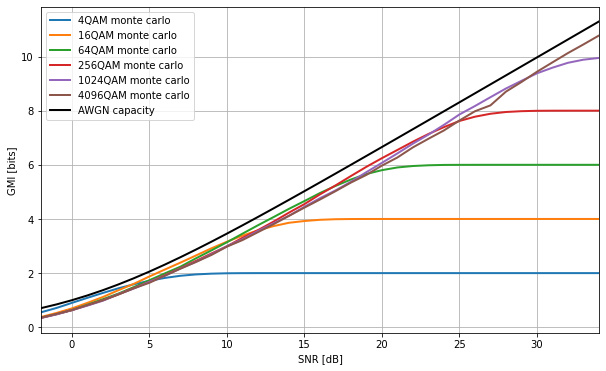

In [6]:
plt.figure(figsize=(10,6))
for ii, M in enumerate(qamOrder):
    plt.plot(SNR, GMI[:,ii],'-', label=str(M)+'QAM monte carlo',linewidth=2)

# plot theoretical AWGN channel capacity    
C = np.log2(1 + 10**(SNR/10))
plt.plot(SNR, C,'k-', label='AWGN capacity',linewidth=2)


plt.xlim(min(SNR), max(SNR))
plt.legend();
plt.xlabel('SNR [dB]');
plt.ylabel('GMI [bits]');
plt.grid()

## Test mutual information (MI) versus signal-to-noise ratio (SNR)

In [4]:
# Run MI vs SNR Monte Carlo simulation 

qamOrder  = [4, 16, 64, 256, 1024]  # Modulation order

SNR  = np.arange(-2, 35, 1)
MI  = np.zeros((len(SNR),len(qamOrder)))

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)
    
    probSymb = 1/M*np.ones(M)    
    mod = QAMModem(m=M)
    constSymb = mod.constellation/np.sqrt(mod.Es)
    
    for indSNR in tqdm(range(SNR.size)):

        snrdB = SNR[indSNR]

        # generate random bits
        bitsTx   = np.random.randint(2, size=2**18)    

        # Map bits to constellation symbols
        symbTx = mod.modulate(bitsTx)

        # Normalize symbols energy to 1
        symbTx = symbTx/np.sqrt(mod.Es)

        # AWGN    
        noiseVar = 1/(10**(snrdB/10))

        symbRx = awgn(symbTx, noiseVar)

        # GMI estimation
        MI[indSNR, ii] = monteCarloMI(symbRx, symbTx, constSymb, probSymb)

run sim: M =  4



run sim: M =  16



run sim: M =  64



run sim: M =  256



run sim: M =  1024


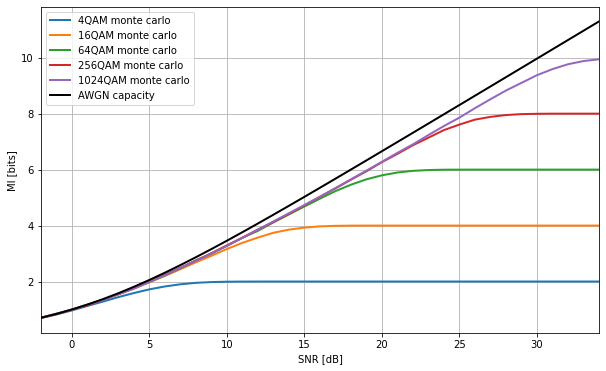

In [5]:
plt.figure(figsize=(10,6))
for ii, M in enumerate(qamOrder):
    plt.plot(SNR, MI[:,ii],'-', label=str(M)+'QAM monte carlo',linewidth=2)

# plot theoretical AWGN channel capacity    
C = np.log2(1 + 10**(SNR/10))
plt.plot(SNR, C,'k-', label='AWGN capacity',linewidth=2)


plt.xlim(min(SNR), max(SNR))
plt.legend();
plt.xlabel('SNR [dB]');
plt.ylabel('MI [bits]');
plt.grid()